In [ ]:
import numpy as np
from math import sqrt
import pandas as pd
import time
import os

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision as tv

from torchvision.models.detection import ssd300_vgg16


import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
np.random.seed(21)
torch.manual_seed(21);

test = [0,2,14,17,28,29,30]

cuda:0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class BCCDDataset(torch.utils.data.Dataset):
    def __init__(self, root='/content/drive/MyDrive/BCCD_Dataset-master/', trans=None):
        super()
        self.root = root
        self.pds = pd.read_csv(os.path.join(root,"test.csv"))
        self.clases = ['Bachground'] + list(self.pds.cell_type.unique())
        self.clases_idx = {w: i for i, w in enumerate(self.clases)}
        self.transforms = tv.transforms.Compose([
               # tv.transforms.Resize([300, 300]),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ])
        self.imgs = self.pds.filename.unique()

    def get_image(self, idx):
        filename = self.imgs[idx]
        img = Image.open(os.path.join(self.root+'BCCD/JPEGImages',filename)).convert("RGB")
        return img

    def __getitem__(self, idx):
        filename = self.imgs[idx]
        img = Image.open(os.path.join(self.root+'BCCD/JPEGImages',filename)).convert("RGB")
        x = self.pds
        x = x[x.filename == filename]
        x = x[x.xmin < x.xmax]
        x = x[x.ymin < x.ymax]
        x = np.array(x)
        for i in range(len(x)):
            x[i,1]=self.clases_idx[x[i,1]]
        labels  = torch.as_tensor(x[:,1].astype(int), dtype=torch.int64).to(device)
        boxes = torch.as_tensor(x[:,[2,4,3,5]].astype(float), dtype=torch.float32).to(device)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(x),), dtype=torch.int64)


        img = self.transforms(img).to(device)

        return img, {'boxes':boxes, 'labels':labels}

    def __len__(self):
        return len(self.imgs)

In [ ]:
model = ssd300_vgg16(pretrained = True).to(device) # weights='DEFAULT',
ds=BCCDDataset()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 235MB/s]


In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%2dm %2ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
model.train()
trainer = torch.optim.Adam(model.parameters(), lr=1e-4)
start = time.time()
eps = 20
trn=list(set(range(len(ds)))-set(test))
for ep in range(eps):
    perm = np.random.permutation(trn)
    i = 0
    l0=0
    l1=0
    l2=0
    ln=0
    while True:
        pp=[]
        tt=[]
        trainer.zero_grad()
        for j in range(50):
            if i >= len(perm):
                break
            p,t = ds[perm[i]]
            pp.append(p)
            tt.append(t)
            i +=1
        pred = model(pp,tt)
        loss = pred['bbox_regression'] * pred['bbox_regression'] * 20 + pred['classification']
        loss.backward()
        trainer.step()
        l1+=pred['bbox_regression'].item()
        l2+=pred['classification'].item()
        l0+=loss.item()
        ln+=1
        if i >= len(perm):
            break
    pc = (ep + 1) / eps
    print('%s (%2d %3d%%) %8.4f %8.4f %8.4f' %
          (timeSince(start, pc),ep,pc*100,l0/ln,l1/ln,l2/ln))

 1m 55s (- 36m 30s) ( 0   5%)  29.3418   1.0245   5.9994
 2m  9s (- 19m 28s) ( 1  10%)  10.5480   0.6323   2.5246
 2m 25s (- 13m 44s) ( 2  15%)   7.4239   0.5142   2.0771
 2m 40s (- 10m 40s) ( 3  20%)   6.4033   0.4730   1.9176
 2m 55s (-  8m 45s) ( 4  25%)   5.4484   0.4260   1.8017
 3m 10s (-  7m 24s) ( 5  30%)   4.7618   0.3890   1.7211
 3m 25s (-  6m 21s) ( 6  35%)   4.2419   0.3571   1.6678
 3m 41s (-  5m 31s) ( 7  40%)   3.9523   0.3413   1.6096
 3m 56s (-  4m 49s) ( 8  45%)   3.7471   0.3279   1.5857
 4m 12s (-  4m 12s) ( 9  50%)   3.3219   0.2971   1.5431
 4m 27s (-  3m 39s) (10  55%)   3.1780   0.2871   1.5222
 4m 43s (-  3m  9s) (11  60%)   2.9375   0.2697   1.4783
 4m 59s (-  2m 41s) (12  65%)   2.6898   0.2493   1.4441
 5m 14s (-  2m 14s) (13  70%)   2.5366   0.2361   1.4170
 5m 29s (-  1m 49s) (14  75%)   2.4093   0.2223   1.4207
 5m 45s (-  1m 26s) (15  80%)   2.2328   0.2081   1.3616
 6m  0s (-  1m  3s) (16  85%)   2.1172   0.1976   1.3353
 6m 16s (-  0m 41s) (17  90%)  

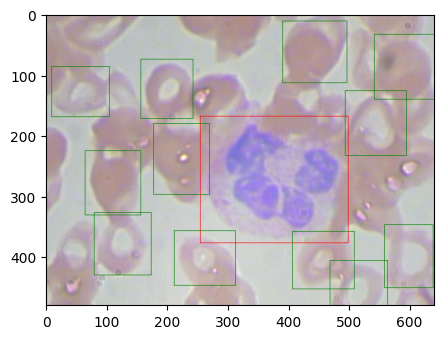

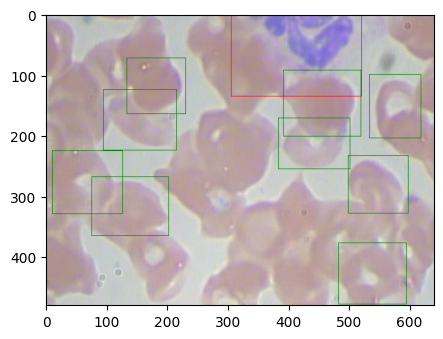

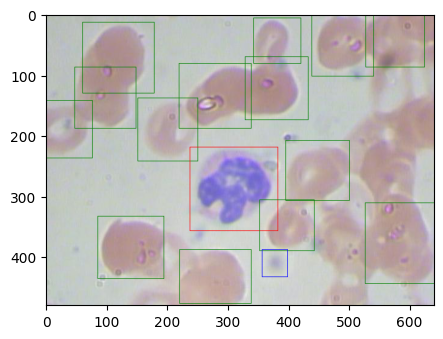

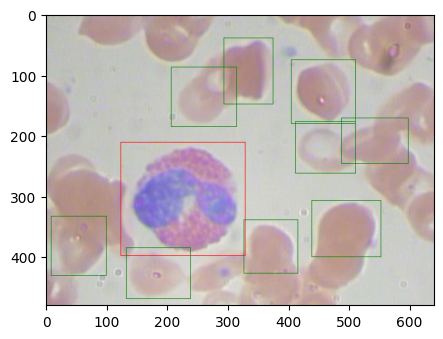

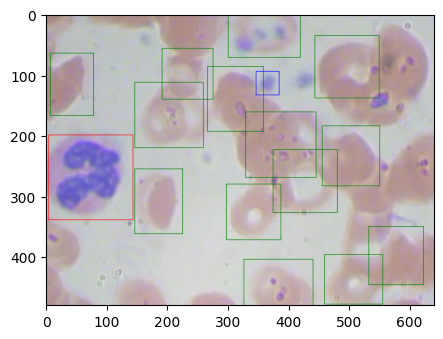

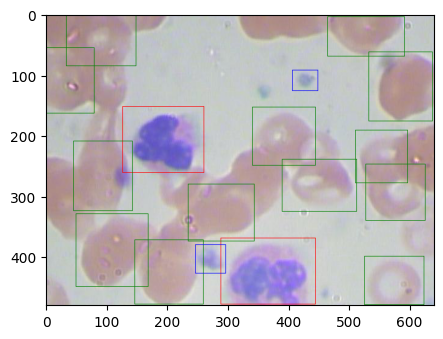

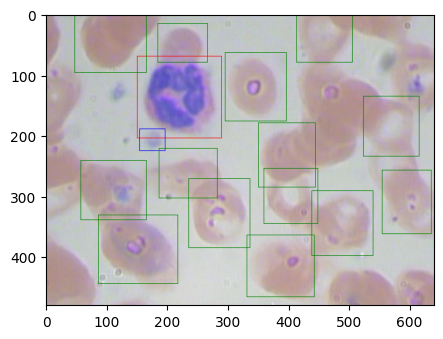

In [ ]:
model.eval()
for i in test:
    p,t = ds[i]
    outputs = model([p])
    img = ds.get_image(i)
    draw = ImageDraw.Draw(img)
    classes = outputs[0]['labels'].cpu().numpy()
    scores = outputs[0]['scores'].detach().cpu().numpy()
    boxes = outputs[0]['boxes'].detach().cpu().numpy()

    for i,box in enumerate(boxes):
        if scores[i] > 0.5 :
            c = classes[i]
            c = c if c < 4 else 0
            cl = ['black','red','green','blue']
            draw.rectangle(xy=box.tolist(), outline=cl[c])
    plt.figure(figsize=(5, 5))
    plt.imshow(img)